In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
warnings.filterwarnings("ignore")
%matplotlib inline

In [12]:
airline_df = pd.read_csv('./Dataset/international-airline-passengers.csv')
airline_df.head()

,Date,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


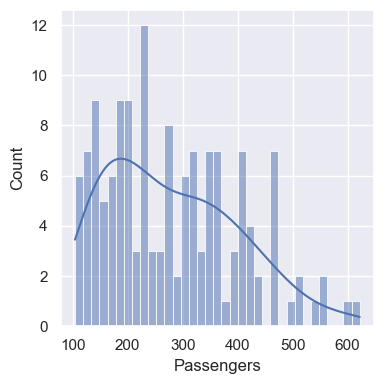

In [46]:
plt.figure(figsize=(4,4))
sns.histplot(airline_df['Passengers'], kde=True, bins=35)
plt.tight_layout()
plt.show()

# Feature Engineering

In [13]:
airline_df.drop(['Date'], axis=1, inplace=True)

In [14]:
airline_df.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [15]:
# airline_lag_df = pd.DataFrame(
#     np.array(
#     pd.concat([
#         airline_df, 
#         airline_df.shift(), 
#         airline_df.shift(2), 
#         airline_df.shift(3), 
#         airline_df.shift(4)], 
#         axis=1
#     )), 
#     columns=['Passengers','Passengers_lag1','Passengers_lag2','Passengers_lag3','Passengers_lag4']
# )

# airline_lag_df.head()

In [16]:
# lagged function, just copas from
# https://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe

def buildLaggedFeatures(s,lag=2, fillna=True, dropna=True):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        res = res.dropna()
    else:
        res = res
    if fillna:
        return res.fillna(0)
    else:
        return res

In [32]:
airline_lag_df = buildLaggedFeatures(airline_df, lag=3, fillna=True, dropna=False)
airline_lag_df.head()

,Passengers,Passengers_lag1,Passengers_lag2,Passengers_lag3
0,112,0.0,0.0,0.0
1,118,112.0,0.0,0.0
2,132,118.0,112.0,0.0
3,129,132.0,118.0,112.0
4,121,129.0,132.0,118.0


In [20]:
X = airline_lag_df.drop('Passengers', axis=1)
y = airline_lag_df['Passengers']

In [21]:
X_train, y_train = X[:101], y[:101]
X_test, y_test = X[101:], y[101:]

# Modelling

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [23]:
lr = LinearRegression()
rf = RandomForestRegressor()
mlp = MLPRegressor(random_state=50)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
mlp.fit(X_train, y_train)

MLPRegressor(random_state=50)

In [24]:
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_mlp = mlp.predict(X_test)

In [25]:
print("Linear Regression")
print("MSE: ", mean_squared_error(y_test, y_pred_lr))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE: ", mean_absolute_error(y_test, y_pred_lr))
print("R2: ", r2_score(y_test, y_pred_lr))
print("")

print("Random Forest Regression")
print("MSE: ", mean_squared_error(y_test, y_pred_rf))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE: ", mean_absolute_error(y_test, y_pred_rf))
print("R2: ", r2_score(y_test, y_pred_rf))
print("")

print("Multilayer Perceptron (MLP) Regression")
print("MSE: ", mean_squared_error(y_test, y_pred_mlp))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))
print("MAE: ", mean_absolute_error(y_test, y_pred_mlp))
print("R2: ", r2_score(y_test, y_pred_mlp))

Linear Regression
MSE:  2102.168584776421
RMSE:  45.8494120439556
MAE:  39.499299468627996
R2:  0.6619192129273492

Random Forest Regression
MSE:  3794.3440050000004
RMSE:  61.59824676888134
MAE:  47.01950000000001
R2:  0.3897754837910741

Multilayer Perceptron (MLP) Regression
MSE:  6168.504459384454
RMSE:  78.53982721768908
MAE:  61.45609581962289
R2:  0.007951665821486209


In [26]:
predict_df = pd.DataFrame(np.array(
    pd.concat([
        pd.DataFrame(np.array(y_test)), 
        pd.DataFrame(y_pred_lr), 
        pd.DataFrame(y_pred_rf), 
        pd.DataFrame(y_pred_mlp)
    ], axis=1)
), columns=['Passengers','Forecast_lr','Forecast_rf','Forecast_mlp'])

In [27]:
predict_df.head()

,Passengers,Forecast_lr,Forecast_rf,Forecast_mlp
0,404.0,457.956427,438.71,475.606526
1,347.0,385.000267,371.27,469.701932
2,305.0,343.857975,321.63,429.141584
3,336.0,305.759690,283.79,372.319095
4,340.0,354.865914,350.86,349.491651


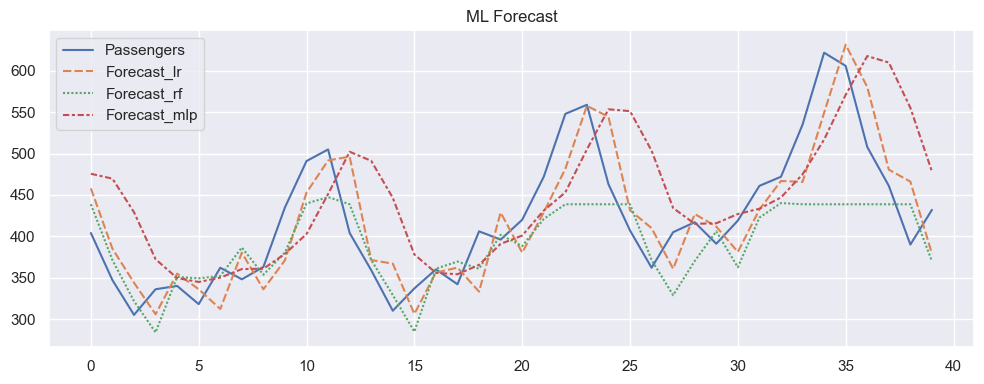

In [28]:
plt.figure(figsize=(10,4))
sns.lineplot(predict_df)
plt.title("ML Forecast")
plt.tight_layout()
plt.show()

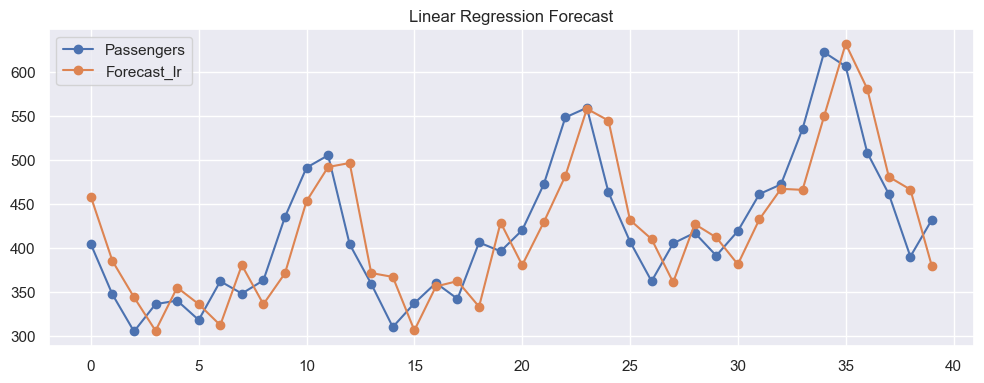

In [29]:
plt.figure(figsize=(10,4))
predict_df['Passengers'].plot(legend=True, marker='o')
predict_df['Forecast_lr'].plot(legend=True, marker='o')
plt.title("Linear Regression Forecast")
plt.tight_layout()
plt.show()

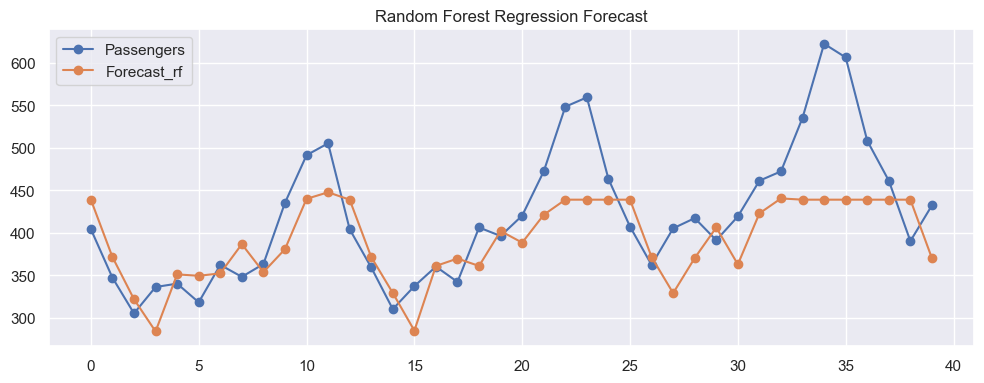

In [30]:
plt.figure(figsize=(10,4))
predict_df['Passengers'].plot(legend=True, marker='o')
predict_df['Forecast_rf'].plot(legend=True, marker='o')
plt.title("Random Forest Regression Forecast")
plt.tight_layout()
plt.show()

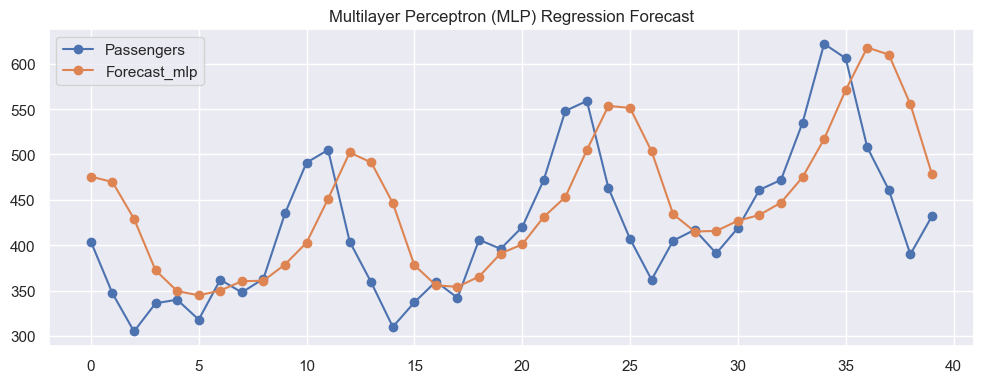

In [31]:
plt.figure(figsize=(10,4))
predict_df['Passengers'].plot(legend=True, marker='o')
predict_df['Forecast_mlp'].plot(legend=True, marker='o')
plt.title("Multilayer Perceptron (MLP) Regression Forecast")
plt.tight_layout()
plt.show()